In [288]:
import numpy as np
import pandas as pd
import math
from scipy.stats import norm, lognorm
import matplotlib.pyplot as plt
from matplotlib import animation
import random 
from pprint import pprint      


def brownian(x0, n, sd = None, loc = None, dt = 1, out = None):
    "Computes the brownian motion with an average increase of loc and DAILY SD of sd. \
    dt is how many prices per day"
    if not out:
        out = np.ones(n)
    # For each element of x0, generate a sample of n numbers from a
    # normal distribution.
    sd = sd or 0.16/(256**0.5)#average actualy market vol
    loc = loc or (1.08)**(1/256)
    r = norm.rvs(loc = loc, size=n, scale=sd*math.sqrt(dt))
    # This computes geometrix Brownian motion by forming the cumulative product of samples. 
    return x0*np.cumprod(r, axis=-1, out = out)

#approximating w/ 4 64 day quarters = 1 year
class Market:
    def __init__(self, year_vol = 0.16, year_ret = 0.08, risk_free = 0.03, num_days = 256*30, price0 = 50):
        """Generates 30 yrs worth of prices.
        This assumes no dividends; how to incorporate?"""
        self.year_vol = year_vol #True expected volatility of ?log? returns
        self.year_ret = year_ret 
        self.risk_free = risk_free
        self.drisk_free = math.log(1 + risk_free)/256#risk free as the daily compounding rate
        self.d_vol = year_vol/math.sqrt(256)#daily vol
        
        self.ret_dist = norm(loc = self.drisk_free, scale = self.d_vol)#lognorm(loc = 0, scale = np.exp(self.drisk_free), s = self.d_vol)
        self.prices = np.exp(np.cumsum(self.ret_dist.rvs(num_days)))#brownian(price0, num_days, sd = self.year_vol, loc = self.year_ret)
        self.process = lambda x0, **kwargs: brownian(x0, num_days, *kwargs)

    #def get_prices; should yield arbitary prices and then remember them using self.process
    #add setters if want specifics returns, cor etc.  
        
class Stock:
    def __init__(self, prices = None, price0 = 50, exp_vol = 0.16, 
                 dividend = 0, market_cor = 1, exp_dvol=None, exp_ret = 0.08, 
                 name = None, const = False):
        """Takes in yearly vol as expected vol, which is distribution from which values drawn"""
        self.exp_vol = exp_vol#yearly
        self.exp_dvol = exp_vol/256**0.5# or exp_dvol or market.d_vol#daily expected vol
        self.drisk_free = math.log(1.03)/256
        self.exp_dret = math.log(1 + exp_ret)/256
        #prices at end of day, assumes started just after dividend paid, 4 dividends/year
        self.dividend = dividend#same every quarter
        self.dividend_every = 64#paid on end of day
        num_days = 30*256
        self.ret_dist = norm(loc = self.exp_dret, scale = self.exp_dvol)#lognorm(loc = 0, scale = np.exp(self.exp_dret), s = self.exp_dvol)
        self.price0 = price0
        if prices is None:
            if const:
                self.true_prices = np.full(num_days, price0)
            else:
                self.true_prices = price0*np.exp(np.cumsum(self.ret_dist.rvs(num_days))) - np.array([[0]*(64 - 1) + [dividend]]*30*4).flatten() 
#             self.true_prices = brownian(price0, n = 30*256, sd = self.exp_dvol, loc = self.exp_dret) \
#                                 - np.array([[0]*(64 - 1) + [dividend]]*30*4).flatten()  #subtract dividend on day paid 
        else:
            self.true_prices = prices
#         self.market = market
        self.name = name or "".join([chr(i) for i in np.random.randint(ord('A'), ord('Z'),4)])
        
    #def get_prices; should yield arbitary prices and then remember them using self.process

    def calc_value(self, spot = None, days_elapsed=0, iv = None):
        if spot is not None:
            return spot
        else:
            return self.true_prices[days_elapsed]
        
    def calc_greeks(self, iv = None, days_elapsed = 0, spot = None):
        delta = 1
        gamma = 0
        vega = 0
        theta = 0#don't make money with day's changing, make money with price changing
        rho = 0#unknown
        return {"Delta":delta, "Gamma":gamma, "Vega":vega/100, "Theta":theta, "Rho":rho/10000}
        
class Euro_Option:
    def __init__(self, strike = 100, premium = 10, lifetime = 256, tp = 'call', asset = None):
        "Defines a European option; if asset None has constant prices at strike"
        self.strike = strike
        self.premium = premium
        self.lifetime = lifetime
        assert(tp in ('put', 'call'))
        self.tp = tp#type
        self.asset = asset or Stock(prices = np.full(lifetime + 1, strike))
        
    def calc_greeks(self, iv = None, days_elapsed = 0, spot = None, ignore = None):#ignore is for extra, unnessisary
        """Calculates the greeks using the BS method.  
        if the implied vol isn't given it takes expected daily for the underlying.
        Computes vol as based on 1pt change, then divides by 100; Rho divide by 10k.
        ignores option premium"""
        days_left = self.lifetime - days_elapsed
        spot = spot or self.asset.true_prices[days_elapsed]
        if days_left == 0:#issue of dividing by 0
            if self.tp == 'call':
                return (int(spot <= self.strike-1), int(abs(spot-self.strike) <= 2), 0, -1, 0)
            elif self.tp == 'put':
                return (-1*int(spot <= self.strike-1), int(abs(spot-self.strike) <= 2), 0, -1, 0)
        drisk_free = self.asset.drisk_free
        if not iv:
            iv = self.asset.exp_dvol
        variance = iv**2
        d1 = (1 / (variance*days_left)**0.5) * (math.log(spot/self.strike) + (drisk_free + variance/2)*days_left)
        d2 = d1 - (variance * days_left)**0.5
        pv_k = self.strike * math.exp(-drisk_free*days_left)
        gamma = norm.pdf(d1)/(spot*(iv*days_left)**0.5)#note uses PDF, not CDF as for d1
        vega = spot*norm.pdf(d1)*(days_left)**0.5
        theta = -spot*norm.cdf(d1)*iv/(2*days_left**0.5)
        if self.tp == 'call':
            delta = norm.cdf(d1)
            theta -= drisk_free*pv_k*norm.cdf(d2)#updates theta
            rho = days_left*pv_k*norm.cdf(d2)
        elif self.tp == 'put':
            delta = norm.cdf(d1) - 1
            theta += drisk_free*pv_k*norm.cdf(-d2)
            rho = -days_left*pv_k*norm.cdf(-d2)
        return {"Delta":delta, "Gamma":gamma, "Vega":vega/100, "Theta":theta, "Rho":rho/10000}#scale down the values
        
    def plot_greek(self, iv = None, days_elapsed = 0, greek='Delta', x_axis='Price'):
        "Plots the greek that is given"
        greek = greek.capitalize()
        x_axis = x_axis.capitalize()
        assert(greek in {'Delta', 'Gamma', 'Vega', 'Theta', 'Rho'})
        assert(x_axis in {'Price', 'Time'})
        if x_axis == 'Price':
            mn = self.asset.true_prices.min()
            mx = self.asset.true_prices.min()
            sd = max(self.asset.true_prices.std(), self.strike/15)
            x_vals = np.arange(mn-4*sd, mx+4*sd, 0.10)
            y_vals = np.array([self.calc_greeks(iv = iv,
                                             days_elapsed = days_elapsed, 
                                             spot = s)[greek] 
                            for s in x_vals])
        elif x_axis == 'Time':
            days_left = self.lifetime - days_elapsed
            time_inc = 1#max(1, days_left/50)
            x_vals = np.arange(days_elapsed, self.lifetime, time_inc)#don't include last day
            y_vals= np.array([self.calc_greeks(iv = iv,
                                             days_elapsed = t)[greek]
                            for t in x_vals])
        fig = plt.figure()
        ax1 = fig.add_subplot(1,1,1)
        ax1.plot(x_vals, y_vals)
        ax1.set_xlabel(x_axis)
        ax1.set_ylabel(greek)
        ax1.set_title(f"{self.tp} with Strike = {self.strike}")#comment out this line if want to turn of type
        return fig
        
    def calc_value(self, spot, days_elapsed=0, iv = None):
        "Given an option; with how many days left and at what price, will return option's value"
        days_left = self.lifetime - days_elapsed
        assert(days_left >= 0)
        if days_left == 0:#issue of dividing by 0
            if self.tp == 'call':
                return max(0, spot - self.strike)
            elif self.tp == 'put':
                return max(0, self.strike - spot)
        if not iv:
            iv = self.asset.exp_dvol
        variance = iv**2
        drisk_free = self.asset.drisk_free
        d1 = (1 / (variance*days_left)**0.5) * (math.log(spot/self.strike) + (drisk_free + variance/2)*days_left)
        d2 = d1 - (variance * days_left)**0.5
        pv_k = self.strike * math.exp(-drisk_free*days_left)
        call = norm.cdf(d1)*spot - norm.cdf(d2)*pv_k
        if self.tp == 'call':
            return call 
        elif self.tp == 'put':
            return pv_k - spot + call
        
    def make_payoff(self, position = 'long', t = 0, scale = 10):
        """Makes payoff diagram at time = t when a option expirs at t=lifetime. 
        Will autoscale if scale = auto"""
        if isinstance(scale, str):
                vol = self.asset.exp_vol
                scale = 2*vol*self.asset.true_prices[t]#sets as 2SD for year
        stock_prices = np.arange(self.strike - scale, self.strike + scale, scale/20)
        payoff = [self.calc_value(spot = i, days_elapsed=t) - self.premium for i in stock_prices]
        fig = plt.figure()
        ax1 = fig.add_subplot(1,1,1) 
        if position == 'long':
            ax1.axhline(y=-self.premium, alpha=0.3, color = 'k')
        else:
            payoff = [i*-1 for i in payoff]
            ax1.axhline(y=self.premium, alpha=0.3, color = 'k')
        ax1.plot(stock_prices, payoff)
        ax1.set_title(f"Option Value at Time = {t}, with expiry at T={self.lifetime}")
        ax1.set_xlabel("stock prices")
        ax1.set_ylabel("Value of Option Position")
        #How to return fig object?, Just displays it
        return fig
    
    @staticmethod
    def rep_option(lifetime = -1, long_short = True, at_maturity = False):
        "creates random options and makes their payoff graphs"
        if lifetime  == -1:
            _lifetime = random.randint(0,256)
        tp = 'call'
        if random.randint(0,100) %2 == 1:
            tp = 'put'
        opt = Euro_Option(strike = np.random.randint(50,150), premium = np.random.randint(5,20), lifetime = _lifetime, tp = tp, asset = None)
        opt.strike = opt.asset.price0 + np.random.randint(-10,10)
        opt.premium = opt.calc_value(opt.asset.price0)
        pos = 'long'
        if long_short and random.randint(0,100) %2 == 1:
            pos = 'short'
        print(opt.asset.price0, opt.premium)
        if at_maturity:
            opt.make_payoff(position = pos, t = _lifetime)
        else:
            opt.make_payoff(position = pos)
        plt.show()
        temp = input("stop?")
        pprint(vars(opt))
        if 'n' in temp.lower():
            Euro_Option.rep_option(lifetime= lifetime, long_short =long_short, at_maturity = at_maturity)
        else:
            return None

#all have same underlying
def portfolio_value(instr, weights, kwarg_lst):
    'given a list of instruments, and kwargs for calc value returns sum\
    indicate Long/Short with a pos/neg amount of instrument'
    return sum([c*i.calc_value(**k) for i,c, k in zip(instr, weights, kwarg_lst)])

def portfolio_greeks(instr, weights, kwarg_lst):
    calc_greeks = [i.calc_greeks(**k) for i,k in zip(instr, kwarg_lst)]
    out = {"Delta":0, "Gamma":0, "Vega":0, "Theta":0, "Rho":0}
    for key in out.keys():
        out[key] = sum([c*g[key] for c,g in zip(weights, calc_greeks)])
    return out

def _plot_port(fn, instr, weights, kwarg_lst, x_axis, price0 = None, tangent = False, 
               xlab ="Price of Underlying", ylab = "Value of portfolio if Instantaneous Jump"):
    price0 = price0 or np.mean(x_axis)
    diff = len(instr) - len(kwarg_lst)
    kwarg_lst = kwarg_lst + [{}]*diff
    initial = fn(instr, weights, [dict(k, spot= price0) for k in kwarg_lst] )
    payoffs = [fn(instr, weights, [dict(k, spot= x) for k in kwarg_lst])
               - initial for x in x_axis]
    plt.plot(x_axis, payoffs)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    if tangent:
        p0_ix = np.searchsorted(x_axis, price0)#np.where(abs(x_axis - price0) <= step_sz)[0][0]
        ix1, ix2 = max(0, p0_ix -1), min(p0_ix + 1, x_axis.size)
        y1, y2 = payoffs[ix1], payoffs[ix2]
        m = (x_axis[ix2] - x_axis[ix1]) /(y2 - y1)
        b = y1 - m*x_axis[ix1]
        plt.plot(x_axis, m*x_axis + b, '--r')

def plot_port_payoff(instr, weights, kwarg_lst, x_axis, price0 = None, tangent = False):
    "plots the graph of the change in the payout of the portfolio"
    _plot_port( portfolio_value, instr, weights, kwarg_lst, x_axis, price0 = price0, tangent = tangent)

def plot_port_greek(instr, weights, kwarg_lst, x_axis, greek = 'Delta', price0 = None, tangent = False):
    fn = lambda instr, weights, kwarg_lst: portfolio_greeks(instr, weights, kwarg_lst)[greek] 
    _plot_port(fn, instr, weights, kwarg_lst, x_axis, price0 = price0, tangent = tangent)

                                    

# Option Types
Calls: The right, but not obligation to buy the "Underlying" at a predetermined price, the "Strike". 

Puts: The right to sell the "Underlying" at the "Strike" of the option. 

You pay a "premium" so your counterparty will give you this privilege.

This privilege is time limited; options have fixed lifetimes 

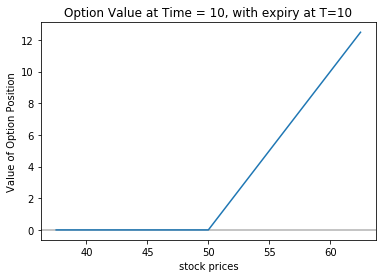

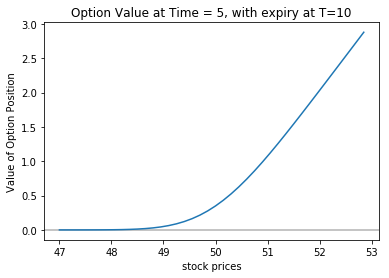

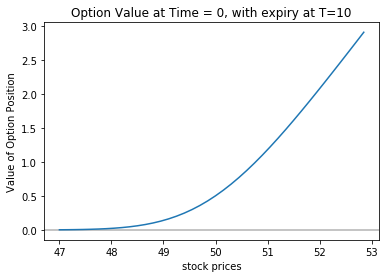

The Greeks
{'Delta': 0.9567570228060056,
 'Gamma': 0.00644567479711804,
 'Rho': 0.047671691833639396,
 'Theta': -0.06450222913163346,
 'Vega': 0.1509404739333614}


In [2]:
#Calls
# risk_free = 0.05
stock = Stock(price0 = 52, exp_vol = 0.12, dividend =0, const =True)
call1 = Euro_Option(strike = 50, premium = 0, lifetime = 10, tp = 'call', asset = stock)
a = call1.make_payoff(position= 'long', t= call1.lifetime, scale = 'auto')
plt.show()
a = call1.make_payoff(position= 'long', t= call1.lifetime//2, scale = 3)
plt.show()
a = call1.make_payoff(position= 'long', scale = 3)
plt.show()
print("The Greeks")
pprint(call1.calc_greeks(days_elapsed = 0))
# print(call1.asset.true_prices)

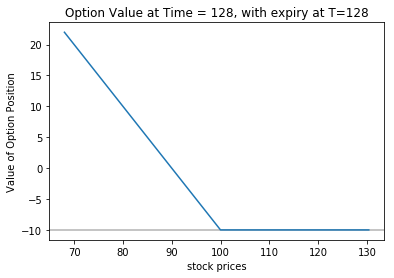

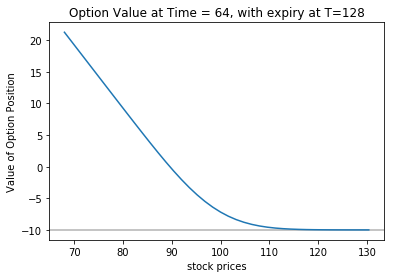

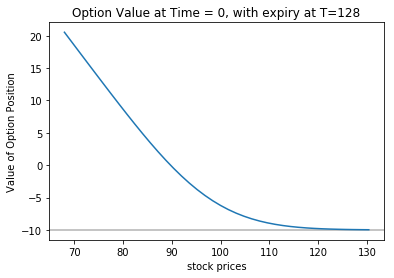

The Greeks:
{'Delta': -0.4933992398068713,
 'Gamma': 0.03988876722146049,
 'Rho': -0.00497330952894672,
 'Theta': -0.24755799443827825,
 'Vega': 0.39888767221460486}


In [3]:
#Puts
put1 = Euro_Option(strike = 100, premium = 10, lifetime = 128, tp = 'put')
put1.make_payoff(position= 'long', t= put1.lifetime, scale= 'auto')
plt.show()
put1.make_payoff(position= 'long', t= put1.lifetime//2, scale= 'auto')
plt.show()
put1.make_payoff(position= 'long', scale= 'auto')
plt.show()
print("The Greeks:")
pprint(put1.calc_greeks(days_elapsed = 127))

# Practice Identifying 
Puts vs. Calls, Being Long vs. Short, and the Option's Strike and Premium

50 3.597823416507971


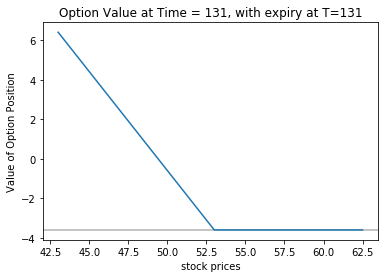

stop?y
{'asset': <__main__.Stock object at 0x0000023CB4DFD7F0>,
 'lifetime': 131,
 'premium': 3.597823416507971,
 'strike': 53,
 'tp': 'put'}


In [224]:
Euro_Option.rep_option(long_short = False, at_maturity= True)#Just put vs. call; identify strike, premium
# Euro_Option.rep_option(at_maturity = True)#Add Long vs. short Position
# #Add Long vs. short time to expiry/low vs. high implied vol, by commenting out line 180
# Euro_Option.rep_option()

# Greeks
Options sensitive to multiple things. The 'greeks' represent how the option price will react to small changes in these values

Delta: The change in the option's price with a 1$ increase in underlying. First derivative of price.

Gamma: The increase in Delta as the underlying increases. Second derivative of price, always positive.

Vega: Change in the value of the Option with a change in the implied Volatility.

Theta: Change in the Option's price with Time. Always negative.

Rho: Option's value sensitivity to interest rates. (Positive for Calls, Negative for Puts) 

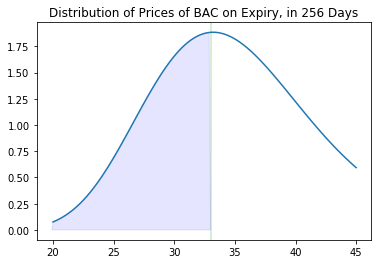

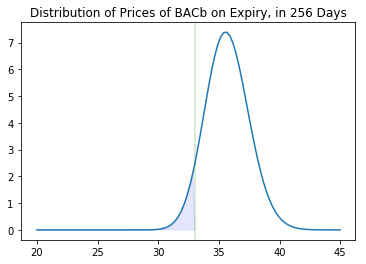

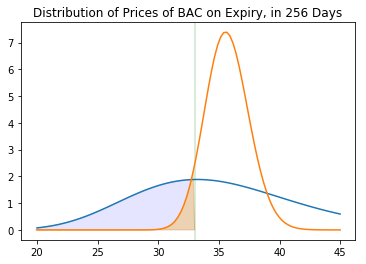

[58.08846115435135, 37.44186933801414, 1.2103443101785203] 2.569992515814155


In [75]:
#Future Stock Prices:

import pylab as p
import os
import contextlib
    
def option_shading(option, prices = None, shading = True, option2 = None, print_exp = False):
    "Given an option plot the pay off region for the asset on expiry"
    n = option.lifetime
    lognorm_scale = np.exp(option.asset.ret_dist.kwds['loc']*n)
    lognorm_shape = option.asset.ret_dist.kwds['scale']*(n**0.5)#takes SD
    p0 = option.asset.price0
    total_ret_dist = lognorm(loc = 0, s = lognorm_shape, scale = lognorm_scale)
    if prices is not None:
        price_idx = prices
    else:
        price_idx = np.linspace(p0*max(0,lognorm_scale - 3*lognorm_shape), p0*(lognorm_scale + 3*lognorm_shape), 1000)
    plt.plot(price_idx, total_ret_dist.pdf(price_idx/p0))
#     plt.plot(p0*total_ret_dist.expect(),0, 'ro')#dot at expected value of stock
    plt.title(f"Distribution of Prices of {option.asset.name} on Expiry, in {n} Days")
    plt.axvline(option.strike, color = 'g', alpha = 0.2)
    if option2:
        n2 = option2.lifetime
        lognorm_scale2 = np.exp(option2.asset.ret_dist.kwds['loc']*n2)
        lognorm_shape2 = option2.asset.ret_dist.kwds['scale']*(n2**0.5)#takes SD
        p0_2 = option2.asset.price0
        total_ret_dist2 = lognorm(loc = 0, s = lognorm_shape2, scale = lognorm_scale2)        
        plt.plot(price_idx, total_ret_dist2.pdf(price_idx/p0_2))
    
    if shading:
        #*Note*: EV is still not the option value(but diverges more than expected)
        if option.tp == "put":
            strike_idx = np.concatenate(([price_idx[0] - 0.1], price_idx[price_idx < option.strike], [option.strike]))
        else:
            strike_idx = np.concatenate(([option.strike], price_idx[option.strike < price_idx], [price_idx[-1] + 0.1]))
        p_strike = np.concatenate(([0], total_ret_dist.pdf(strike_idx[1:-1]/p0), [0]))
        p.fill(strike_idx, p_strike, alpha = 0.1, color = 'b')
        if option2 is not None:
            if option2.tp == "put":
                strike_idx2 = np.concatenate(([price_idx[0] - 0.1], 
                                              price_idx[price_idx < option.strike], 
                                              [option2.strike]))
            else:
                strike_idx2 = np.concatenate(([option2.strike],
                                              price_idx[option2.strike < price_idx], 
                                              [price_idx[-1] + 0.1]))
            p_strike2 = np.concatenate(([0], total_ret_dist2.pdf(strike_idx2[1:-1]/p0_2), [0]))
            p.fill(strike_idx2, p_strike2, alpha = 0.3, color = 'Orange')
    if print_exp: 
        if option.tp == "put":
            print(f"Expected Value of Stock 1: {p0*total_ret_dist.expect()}\n",
                    "Expected Value of 'Option' at Expiry is: ", 
                      total_ret_dist.expect(func = lambda i: option.strike - i*p0, 
                                        ub = option.strike/p0))
        else:
            print(f"Expected Value of Stock 1: {p0*total_ret_dist.expect()}\n",
                    "Expected Value of 'Option' at Expiry is: ", 
                      total_ret_dist.expect(func = lambda i: i*p0 - option.strike, 
                                        lb = option.strike/p0))
        if option2 is not None:
            if option2.tp == "put":
                        print(f"Expected Value of Stock 2: {p0_2*total_ret_dist2.expect()}\n",
                            "Expected Value of 'Option' at Expiry is: ", 
                              total_ret_dist.expect(func = lambda i: option2.strike - i*p0_2, 
                                                ub = option2.strike/p0_2))
            else:
                print(f"Expected Value of Stock 2: {p0_2*total_ret_dist2.expect()}\n",
                        "Expected Value of 'Option' at Expiry is: ", 
                          total_ret_dist2.expect(func = lambda i: i*p0_2 - option2.strike, 
                                            lb = option2.strike/p0_2))
    plt.show()#Comment, uncomment this line, grib!!
    
baml = Stock(price0 = 32, exp_vol = 0.2, name = "BAC")
baml_b = Stock(price0 = 33, exp_vol = 0.05, name = "BACb")
tesla = Stock(price0 = 325, exp_vol = 0.497, name = "TSLA")

call1 = Euro_Option(strike = 350, premium = 10, lifetime = 256, tp = 'call', asset = tesla)
call2 = Euro_Option(strike = 350, premium = 10, lifetime = 128, tp = 'call', asset = tesla)
call3 = Euro_Option(strike = 350, premium = 10, lifetime = 4, tp = 'call', asset = tesla)#doesn't match true prices

put1 = Euro_Option(strike = 33, premium = 10, lifetime = 256, tp = 'put', asset = baml)
put1b = Euro_Option(strike = 33, premium = 10, lifetime = 256, tp = 'put', asset = baml_b)

# option_shading(call1, prices = np.linspace(0,1000, 10000))
# option_shading(call2, prices = np.linspace(0,1000, 10000))
# option_shading(call3, prices = np.linspace(0,1000, 10000))
option_shading(put1, prices = np.linspace(20,45,100))
option_shading(put1b, prices = np.linspace(20,45,100))
option_shading(put1, option2 = put1b, prices = np.linspace(20,45,100), print_exp = False)

print([op.calc_value(tesla.price0) for op in [call1, call2, call3]], 
      put1.calc_value(baml.price0))

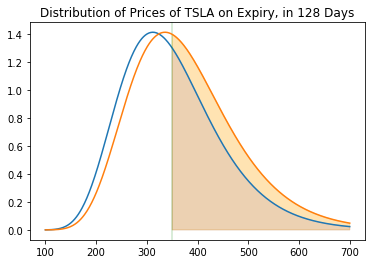

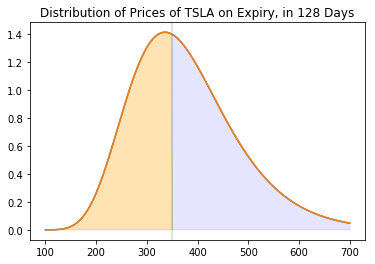

{'Delta': 0.5984769598893233, 'Gamma': 0.0006080140945043442, 'Vega': 15.556852051585135, 'Theta': -0.254486236357727, 'Rho': 2.1482666432043684}


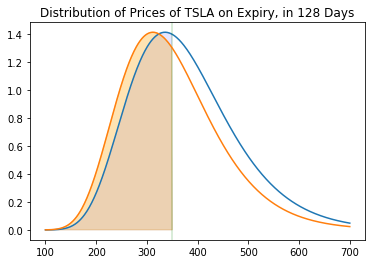


Delta In-the-Money


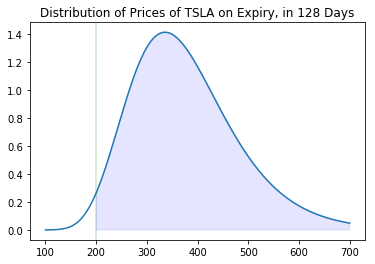

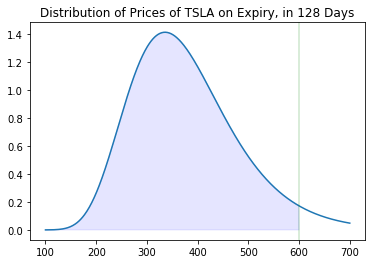


Delta out of the money


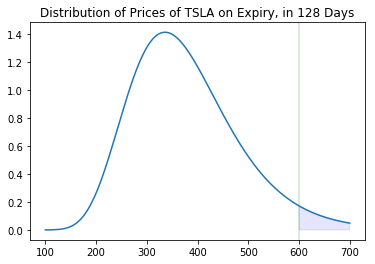

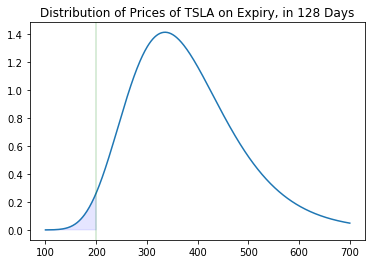

In [23]:
#Delta Intuition
tesla = Stock(price0 = 325, exp_vol = 0.4, name = "TSLA")
call1 = Euro_Option(strike = 350, premium = 10, lifetime = 128, tp = 'call', asset = tesla)
tesla_p = Stock(price0 = 350, exp_vol = 0.4, name = "TSLA")
call2 = Euro_Option(strike = 350, premium = 10, lifetime = 128, tp = 'call', asset = tesla_p)
#Shows change in distribution
option_shading(call1, prices = np.linspace(100, 700, 500), option2 = call2)

#Shows delta < 1
put2 = Euro_Option(strike = 350, premium = 10, lifetime = 128, tp = 'put', asset = tesla_p)
option_shading(call2, prices = np.linspace(100, 700, 500), option2 = put2, print_exp = False)
print(call2.calc_greeks())

#Put Intuition
put1 = Euro_Option(strike = 350, premium = 10, lifetime = 128, tp = 'put', asset = tesla)
option_shading(put2, prices = np.linspace(100, 700, 500), option2 = put1)#but delta < 1

print("\nDelta In-the-Money")
call3 = Euro_Option(strike = 200, premium = 10, lifetime = 128, tp = 'call', asset = tesla_p)
option_shading(call3, prices = np.linspace(100, 700, 500))
put4 = Euro_Option(strike = 600, premium = 10, lifetime = 128, tp = 'put', asset = tesla_p)
option_shading(put4, prices = np.linspace(100, 700, 500))
# option_shading(call3, prices = np.linspace(100, 700, 500))

print("\nDelta out of the money")
call4 = Euro_Option(strike = 600, premium = 10, lifetime = 128, tp = 'call', asset = tesla_p)
option_shading(call4, prices = np.linspace(100, 700, 500))
put3 = Euro_Option(strike = 200, premium = 10, lifetime = 128, tp = 'put', asset = tesla_p)
option_shading(put3, prices = np.linspace(100, 700, 500))
# option_shading(call4, prices = np.linspace(100, 700, 500))


In [ ]:
#Call Delta
call1.strike = 50
a = Euro_Option.plot_greek(call1, x_axis = 'Price')
a.show()
call1.strike = 45
a = Euro_Option.plot_greek(call1, x_axis = 'Price')
a.show()
call1.strike = 55
a = Euro_Option.plot_greek(call1, x_axis = 'Price')
a.show()
print(call1.strike, call1.asset.true_prices)

In [ ]:
#Put Delta
put1 = Euro_Option(strike = 50, premium = 10, lifetime = 128, tp = 'put')
a = Euro_Option.plot_greek(put1, x_axis = 'Price')
a.show()
put1.strike = 45
a = Euro_Option.plot_greek(put1, x_axis = 'Price')
a.show()
put1.strike = 55
a = Euro_Option.plot_greek(put1, x_axis = 'Price')
a.show()
print(put1.strike, put1.asset.true_prices)

In [ ]:
#Call Gamma
call1.strike = 50
a = Euro_Option.plot_greek(call1, greek='Gamma', x_axis = 'Price')
a.show()
call1.strike = 45
a = Euro_Option.plot_greek(call1, greek='Gamma',x_axis = 'Price')
a.show()
call1.strike = 55
a = Euro_Option.plot_greek(call1,greek='Gamma', x_axis = 'Price')
a.show()
b = Euro_Option.plot_greek(call1,greek='Gamma', x_axis = 'Time')
b.show()

In [ ]:
#Put Gamma
put1 = Euro_Option(strike = 50, premium = 10, lifetime = 128, tp = 'put')
a = Euro_Option.plot_greek(put1, greek='Gamma',x_axis = 'Price')
a.show()
put1.strike = 45
a = Euro_Option.plot_greek(put1, greek='Gamma', x_axis = 'Price')
a.show()
put1.strike = 55
a = Euro_Option.plot_greek(put1, greek='Gamma', x_axis = 'Price')
a.show()
b = Euro_Option.plot_greek(put1,greek='Gamma', x_axis = 'Time')
b.show()


 Vega when In-the-Money


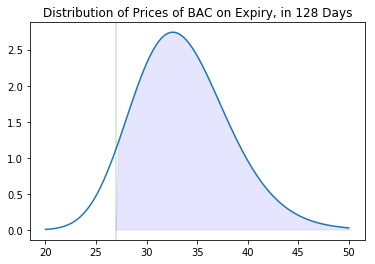

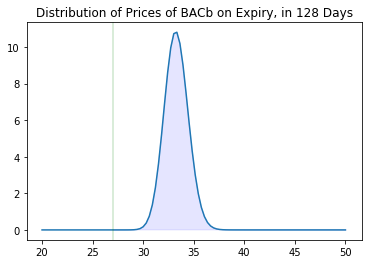


 Vega when Out of the money


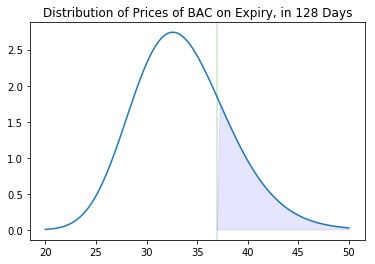

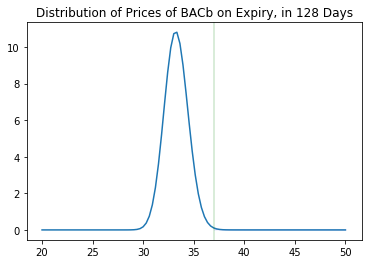


 Vega when at the money


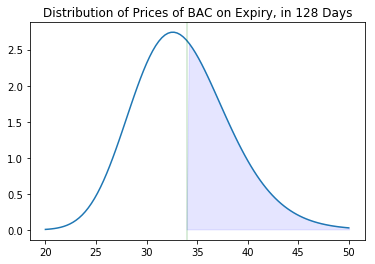

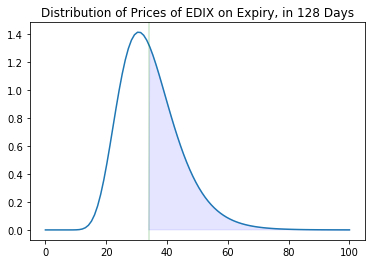

In [32]:
#Vega Intuition
baml = Stock(price0 = 32, exp_vol = 0.2, name = "BAC")
baml_b = Stock(price0 = 32, exp_vol = 0.05, name = "BACb")
risky = Stock(price0 = 32, exp_vol = 0.4, name = "EDIX")

print("\n Vega when In-the-Money")
#When in the money, the vega of an option is lower
call5 = Euro_Option(strike = 27, premium = 10, lifetime = 128, tp = 'call', asset = baml)
call6 = Euro_Option(strike = 27, premium = 10, lifetime = 128, tp = 'call', asset = baml_b)
option_shading(call5, prices = np.linspace(20, 50, 100))
# option_shading(call6, prices = np.linspace(20, 50, 100), option2 =call5)#vega increases
option_shading(call6, prices = np.linspace(20, 50, 100))

print("\n Vega when Out of the money")
#When Near the money, vega higher
call5.strike = 37#out
call6.strike = 37
option_shading(call5, prices = np.linspace(20, 50, 100))
option_shading(call6, prices = np.linspace(20, 50, 100))

print("\n Vega when at the money")
call5.strike = 34#near
option_shading(call5, prices = np.linspace(20, 50, 100))
call7 = Euro_Option(strike = 34, premium = 10, lifetime = 128, tp = 'call', asset = risky)
option_shading(call7, prices = np.linspace(0, 100, 100))


In [ ]:
#Call Vega
call1.strike = 50
a = Euro_Option.plot_greek(call1, greek='Vega', x_axis = 'Price')
a.show()
call1.strike = 45
a = Euro_Option.plot_greek(call1, greek='Vega',x_axis = 'Price')
a.show()
call1.strike = 55
a = Euro_Option.plot_greek(call1,greek='Vega', x_axis = 'Price')
a.show()
b = Euro_Option.plot_greek(call1,greek='Vega', x_axis = 'Time')
b.show()

In [ ]:
#Put Vega
put1 = Euro_Option(strike = 50, premium = 10, lifetime = 128, tp = 'put')
a = Euro_Option.plot_greek(put1, greek='Vega',x_axis = 'Price')
a.show()
put1.strike = 45
a = Euro_Option.plot_greek(put1, greek='Vega', x_axis = 'Price')
a.show()
put1.strike = 55
a = Euro_Option.plot_greek(put1, greek='Vega', x_axis = 'Price')
a.show()
b = Euro_Option.plot_greek(put1,greek='Vega', x_axis = 'Time')
b.show()

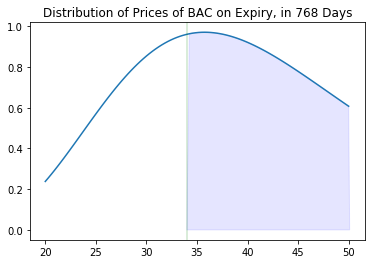

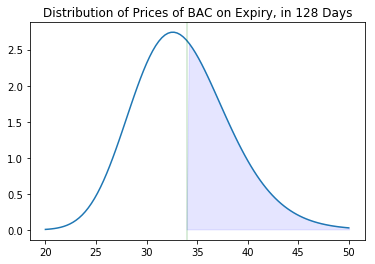

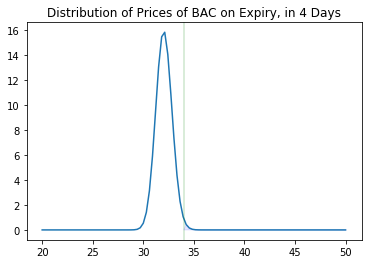

In [34]:
#Theta Intutition: Inverse of Vega but with more Time to grow. Less chance to realize Vol.
call5.lifetime = 768#3 years
option_shading(call5, prices = np.linspace(20, 50, 100))
call5.lifetime = 128#1/2 year
option_shading(call5, prices = np.linspace(20, 50, 100))
call5.lifetime = 4#1/2 year
option_shading(call5, prices = np.linspace(20, 50, 100))

In [ ]:
#Call Theta
call1.strike = 50
a = Euro_Option.plot_greek(call1, greek='Theta', x_axis = 'Price')
a.show()
call1.strike = 45
a = Euro_Option.plot_greek(call1, greek='Theta',x_axis = 'Price')
a.show()
call1.strike = 55
a = Euro_Option.plot_greek(call1,greek='Theta', x_axis = 'Price')
a.show()
b = Euro_Option.plot_greek(call1,greek='Theta', x_axis = 'Time')
b.show()
call1.strike = 45
b = Euro_Option.plot_greek(call1,greek='Theta', x_axis = 'Time')
b.show()

In [ ]:
#Put Theta
put1 = Euro_Option(strike = 50, premium = 10, lifetime = 128, tp = 'put')
a = Euro_Option.plot_greek(put1, greek='Theta',x_axis = 'Price')
a.show()
put1.strike = 45
a = Euro_Option.plot_greek(put1, greek='Theta', x_axis = 'Price')
a.show()
put1.strike = 55
a = Euro_Option.plot_greek(put1, greek='Theta', x_axis = 'Price')
a.show()
b = Euro_Option.plot_greek(put1, greek='Theta', x_axis = 'Time')
b.show()
put1.strike = 45
b = Euro_Option.plot_greek(put1, greek='Theta', x_axis = 'Time')
b.show()

# Value = Time Value + Instrinsic Value
There's 2 components of option value, the Instrinsic value(Value if excersised today) and Time Value(Value it might go up).

Theta is the decrease in Timve Value

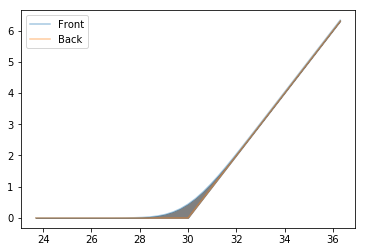

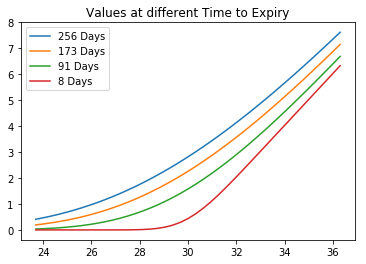

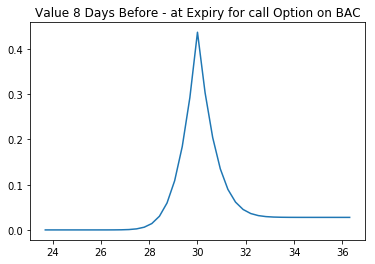

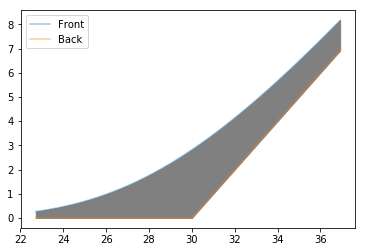

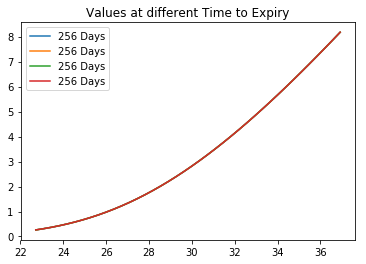

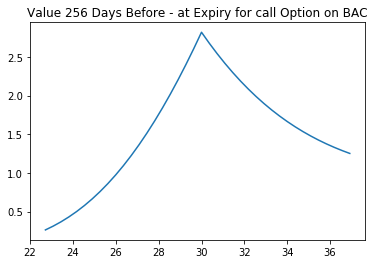

In [260]:
def plot_time_val(option, x_axis = None, t= 0):
    "Plot Differnce in value at Present vs. Expiry"
    vol = option.asset.exp_vol
    scale = vol*option.asset.true_prices[t] or 10#sets as 2SD for year
    x_axis = x_axis or np.arange(option.strike - scale, option.strike + scale, scale/20)
    val = [option.calc_value(spot = i, days_elapsed=option.lifetime - t)  for i in x_axis]
    intrinsic = [option.calc_value(spot = i, days_elapsed=option.lifetime) for i in x_axis]
    time_val = [i-j for i,j in zip(val, intrinsic)]
    plt.plot(x_axis, val, alpha = 0.4)
    plt.plot(x_axis, intrinsic, alpha = 0.4)
    plt.fill_between(x_axis, intrinsic, val, color = 'grey')
    plt.legend(("Front", "Back"))
    plt.show()
    plt.title("Values at different Time to Expiry")
#     plt.legend([for i in np.linspace(0, option.lifetime - t, 4)])
    for e in np.linspace(0, option.lifetime - t, 4):
        val = [option.calc_value(spot = i, days_elapsed=e)  for i in x_axis]
        plt.plot(x_axis, val, label = f"{option.lifetime - e:.0f} Days" )
    plt.legend()
    plt.show()
    plt.plot(x_axis, time_val)
    plt.title(f"Value {t} Days Before - at Expiry for {option.tp} Option on {option.asset.name}")
    plt.show()
    
    
call_option = Euro_Option(strike = 30, premium = 0, lifetime = 256, tp = 'call', asset = baml)
put_option = Euro_Option(strike = 30, premium = 0, lifetime = 256, tp = 'put', asset = baml)
for o in [call_option]:#, put_option]:
    for t in [8, 256]:
        plot_time_val(o, t= t)

# Hedging
Greeks are additive: if have a position with a delta of 0.8, vega of 0.5 and theta of 0.1, and the price goes up by 1/2 a dollar tommorow, but the implied vol drops by 2pts then what's the change in position?  0.8 \* 0.5 -0.5\*2+0.1\*1 = \$ 0.5 dollars.

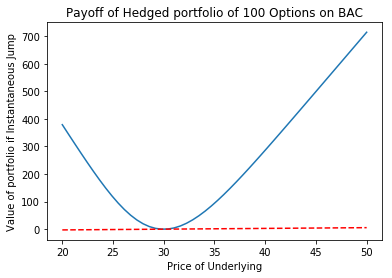

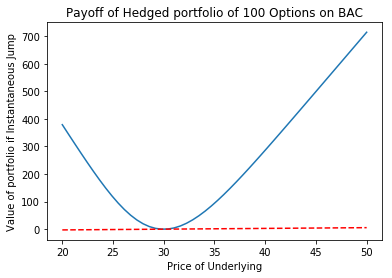

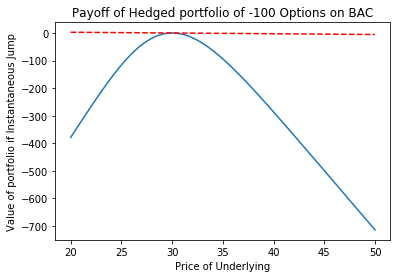

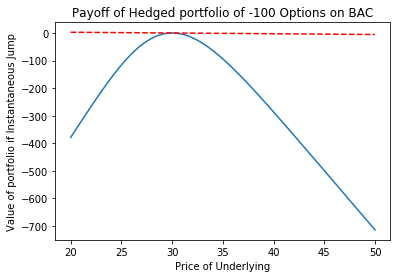

In [281]:
def option_stock_graph(option, stock, position = 100, price0 = 25, x_axis = np.linspace(15,50), 
                       days_elapsed = 0, tangent = False):
    d_hedge = option.calc_greeks(spot = price0, days_elapsed = days_elapsed)['Delta']
    instr = [option, stock]
    weights = [position, -position*d_hedge]
    kwarg_lst = [{'days_elapsed': days_elapsed}, {'spot':0}]
    plot_port_payoff(instr, weights, kwarg_lst, x_axis, tangent = tangent, price0 = price0)
    plt.title(f"Payoff of Hedged portfolio of {position} Options on {stock.name}")
    plt.show()
    
p0 = baml.strike    
call_option = Euro_Option(strike = 30, premium = 0, lifetime = 128, tp = 'call', asset = baml)
put_option = Euro_Option(strike = 30, premium = 0, lifetime = 128, tp = 'put', asset = baml)
x_axis = np.linspace(20,50)

option_stock_graph(call_option, baml, tangent = True, x_axis = x_axis, price0 =p0)
option_stock_graph(put_option, baml, tangent = True, x_axis = x_axis, price0 =p0)
option_stock_graph(call_option, baml, position = -100,  tangent = True, x_axis = x_axis, price0 =p0)
option_stock_graph(put_option, baml, position = -100, tangent = True, x_axis = x_axis, price0 =p0)



# Types of Spreads

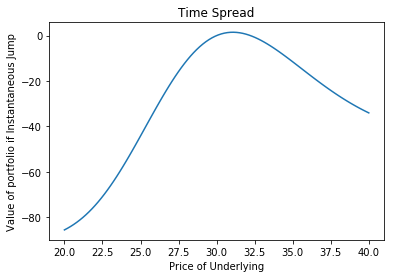

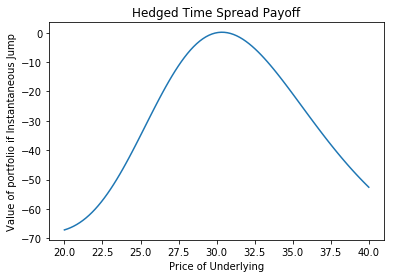

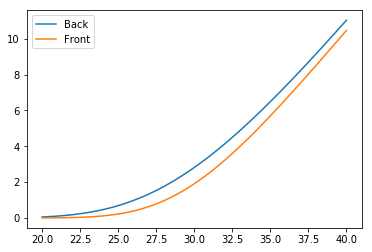

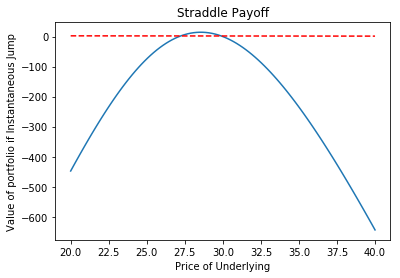

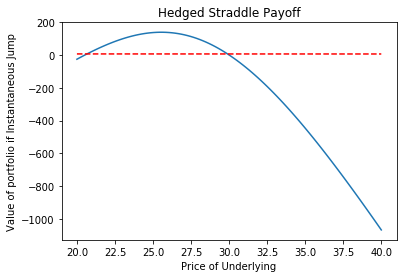

In [282]:
baml.strike = 30
option = Euro_Option(strike = 30, premium = 0, lifetime = 256, tp = 'call', asset = baml)
x_axis = np.linspace(20,40, 100)
sz = 100

def time_spread(t1=256, t2=128, strike = 30, days_elapsed =0, hedged = True, greeks = None):
    #Time spread: short prompt, long back
    option = Euro_Option(strike = strike, premium = 0, lifetime = t1, tp = 'call', asset = baml)
    option2 = Euro_Option(strike = strike, premium = 0, lifetime = t2, tp = 'call', asset = baml)
    plot_port_payoff([option, option2], 
                     [sz,-sz],
                     [{'days_elapsed':days_elapsed},{'days_elapsed':days_elapsed},{'spot':0}],
                     x_axis)
    plt.title("Time Spread")
    plt.show()
    if hedged:
        d_hedge = option.calc_greeks()['Delta']
        d_hedge -= option2.calc_greeks(days_elapsed=days_elapsed)['Delta']
        plot_port_payoff([option, option2, baml], 
                         [sz,-sz,d_hedge*sz], 
                         [{'days_elapsed':days_elapsed},{'days_elapsed':days_elapsed},{'spot':0}],
                         x_axis)
        plt.title("Hedged Time Spread Payoff")
        plt.show()
        val = [option.calc_value(spot = i, days_elapsed=days_elapsed)  for i in x_axis]
        val2 = [option2.calc_value(spot = i, days_elapsed=days_elapsed)  for i in x_axis]
        plt.plot(x_axis, val)
        plt.plot(x_axis, val2)
    #     plt.fill_between(x_axis, val, val2, color = 'grey')
        plt.legend(("Back", "Front"))
        plt.show()
time_spread(days_elapsed=0)

#Stradle: Short Put and Call w/ same strike
def straddle(strike):
    #Note that this position is NOT delta nuetral if strike = spot as the stock is expected to grow. 
    #Based on expectations upon expiry call is slightly in the money.
    option = Euro_Option(strike = strike, premium = 0, lifetime = 256, tp = 'call', asset = baml)
    p_option = Euro_Option(strike = strike, premium = 0, lifetime = 256, tp = 'put', asset = baml)
   
    plot_port_payoff([option, p_option], [-sz,-sz], [{'days_elapsed':0},{'days_elapsed':0}], x_axis, tangent = True)
    plt.title("Straddle Payoff")
    plt.show()

    d_hedge = -option.calc_greeks()['Delta']
    d_hedge -= p_option.calc_greeks()['Delta']
    plot_port_payoff([option, p_option, baml], [-sz, -sz, sz*d_hedge], [{'days_elapsed':0},{'days_elapsed':0},{'spot':0}], x_axis, tangent = True)
    plt.title("Hedged Straddle Payoff")
    plt.show()
straddle(30) 
# straddle(30*1.08) #fixes 'issue' with straddle

# d_hedge += option.calc_greeks(days_elapsed=250)['Delta']
# plot_port_payoff([option, option, stock], [sz0,sz0, -sz0*d_hedge], [{'days_elapsed':0},{'days_elapsed':250},{'spot':0}], x_axis)


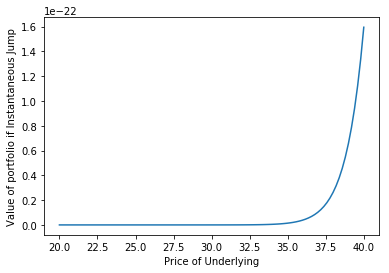

In [291]:
#Make Arbitrary Spread
instr = [call1, asdf, call3, call4]
weights = [1, -1, 1, -1]
kwarg_lst = []
plot_port_greek(instr, weights, kwarg_lst, x_axis, greek='Theta')

In [ ]:
#Make animations
fig = plt.figure()
ax = plt.axes(xlim=(40, 60), ylim=(-10, 10))#sets limits
line, = ax.plot([], [], lw=2)


def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def anim_price(option, t, iv = None):
    "Animate the change in price of an option from issuance to expiry"
    spot = option.asset.true_prices[t]
    scale = 10#max(underlying_prx) - min(underlying_prx)
    stock_prices = np.arange(option.strike - scale, self.strike + scale, scale/20)
    y = [option.calc_value(i, days_elapsed=t, iv = iv) for i in stock_prices]
    print(stock_prices, y)
    line.set_data(stock_prices, y)
    return line,

animate = lambda i: anim_price(call2, i)
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

#need to get saving working to display
# anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.show()

In [ ]:
##Show that distribution matches
option = Euro_Option(strike = 350, premium = 10, lifetime = 128, tp = 'call', asset = tesla)
n = option.lifetime
lognorm_scale = np.exp(option.asset.ret_dist.kwds['loc']*n)
lognorm_shape = option.asset.ret_dist.kwds['scale']*(n**0.5)#takes SD
p_0 = option.asset.price0
#NOTE!!! Below is NOT the true total_ret_dist, is why prices diverge
total_ret_dist = lognorm(loc = 0, s = lognorm_shape, scale = lognorm_scale)
price_idx = np.linspace(p_0*max(0,lognorm_scale - 3*lognorm_shape), p_0*(lognorm_scale + 3*lognorm_shape), 1000)
price_idx = np.linspace(0,5,100)
plt.plot(price_idx, total_ret_dist.pdf(price_idx))

s = 10000
samples = [0]*s
num_days = option.lifetime
for i in range(s):
    samples[i] = np.exp(np.cumsum(option.asset.ret_dist.rvs(num_days)))[-1]
shape, loc, scale = lognorm.fit(samples, floc = 0)
print(scale, lognorm_scale, shape, lognorm_shape)
plt.hist(samples, density = True, bins = 50)
plt.show()

In [ ]:
#ignore
market = Market(risk_free = 0.0)
tstock = Stock(market = market, exp_vol = 0.12, price0 = 52)
call2 = Euro_Option(strike = 50, lifetime = 8, asset = tstock)
call2.calc_value(spot=52, days_elapsed=0)


#Distribution of of future stock returns 
#Probability Distribution of Black-Scholes returns
from scipy.stats import lognorm, norm
# print(ret_dist.pdf(0.001), ret_dist.pdf(0.999), rets)
# logsample = ret_dist.rvs(size=1000) 
# sample = np.exp(logsample)
# shape, loc, scale = lognorm.fit(sample, floc=0)#holds loc to 0
# print(shape, scale)
# print(d_vol, np.exp(d_ret))


#shape = d_vol, scape = np.exp(Mu)
def plot_price_moves(d_ret = math.log(1 + 0.08)/256, d_vol = year_vol/math.sqrt(256), t = 256, x_axis = None):
    t_ret = d_ret*t
    t_vol = d_vol*(t**0.5)
#     print(t_ret, year_ret, t_vol, year_vol)
    price_dist = lognorm(loc = 0, scale = np.exp(t_ret), s = t_vol)
    if x_axis is not None:
        rets = x_axis
    else:
        rets = np.linspace(np.exp(t_ret)- 3*t_vol, np.exp(t_ret) + 3*t_vol, 100)
    plt.plot(rets, price_dist.pdf(rets))
    plt.title(f"Distribution of Prices after {t} Days")
    plt.show()
    return price_dist
# plot_price_moves(t=1, x_axis = np.linspace(0,2))
# plot_price_moves()

stock = Stock(price0 = 52, exp_vol = 0.12, dividend =0)
call1 = Euro_Option(strike = 50, premium = 10, lifetime = 128, tp = 'call')
# def shade_option_value(Option):
d_ret = np.log(1+0.08)/256
d_vol = 0.16/256**0.5
reps = 100
year_price = [0]*reps
for i in range(reps):
    n = 256*9
    t_ret = d_ret*n
    t_vol = d_vol*n**0.5
    ret_dist = norm(loc = d_ret, scale = d_vol)
    samples = ret_dist.rvs(n)
#     print("sm", np.cumsum(samples)[-1], np.sum(samples))
    prices = np.exp(np.cumsum(samples))
    year_price[i] = prices[-1]

#Mean and Variance don't match up??!?!, SD, Mean are above what is expected
print(np.std(year_price), d_vol*(n)**0.5, np.mean(year_price), np.exp(d_ret*n))
plt.hist(year_price, density = True)
price_dist = plot_price_moves(d_ret = d_ret, d_vol = d_vol, t = n, x_axis = np.linspace(0,10,1000))
